As climate change is on the rise wildfire are becoming more frequent. The report from the Trump administration said that the warmer our country gets the more combustible it will be, and that with continued release of greenhouse gases fires will be more frequent. Fires may no longer just be a Western United States problem but a national problem. We know this because we have already seen increased burning in the West from dryer forests, warmer summers resulting in less snow, droughts, and by looking at human behavior where people are increasingly intruding into wildland areas. Unfortunately, this will only worsen climate change as fires increase carbon emissions setting off a deadly positive feedback loop.

Pierre-louis, K., &amp; Popovich, N. (2018, November 27). Climate change is fueling wildfires nationwide, New Report warns. The New York Times. https://www.nytimes.com/interactive/2018/11/27/climate/wildfire-global-warming.html 

In [3]:
import os
import warnings

import earthpy as et
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import pandas as pd
import pyogrio

# warning.simplefilter('ignore')

### Change for NHD
The watershed boundary dataset is hydrologic unit dataset, which represent the area of the landscape that drains toa  portion of the stream network. They are determined based on topographic, hydrologic, an dother landscape characteristics. There are six hierarchial levels (two optional). The hydrologic unit codes (HUC) are made using a two digit system. The smaller areal unit is idneitited by adding two digitis to the identifying code, the sammer unit is nested within (2-16 digit codes).

Access National Hydrography Products. Access National Hydrography Products | U.S. Geological Survey. (n.d.). https://www.usgs.gov/national-hydrography/access-national-hydrography-products 

In [8]:
# Downloading data and putting it into directory
nhd_url = (
    "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/HU4/"
    "GDB/NHD_H_0101_HU4_GDB.zip")
nhd_dir = et.data.get_data(url=nhd_url)
nhd_dir

Extracted output to /home/jovyan/earth-analytics/data/earthpy-downloads/NHD_H_0101_HU4_GDB


'/home/jovyan/earth-analytics/data/earthpy-downloads/NHD_H_0101_HU4_GDB'

In [9]:
nhd_path = os.path.join(nhd_dir, 'NHD_H_0101_HU4_GDB.gdb')
nhd_hu4_gdf = gpd.read_file(nhd_path, layer='WBDHU4', from_disk=True)
nhd_hu4_gdf

,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc4,name,shape_Length,shape_Area,geometry
0,{AAB11E45-75A7-47FE-85F1-AB3621CD80BD},NaN,NaN,NaN,NaN,2019-10-15 17:01:06+00:00,NaN,9015709.69,36485.31,"CN,ME",0101,St. John,20.685066,4.301762,"MULTIPOLYGON (((-68.44994 48.09251, -68.44858 ..."


### National Hydrology (HU4) area

<Axes: >

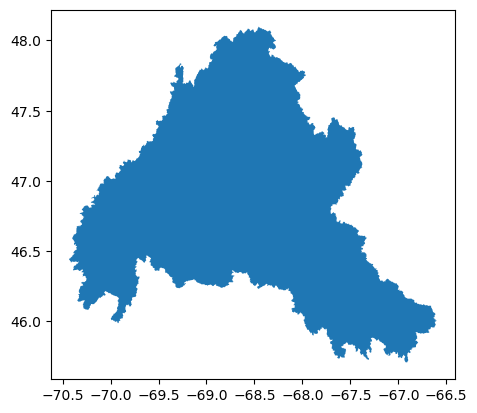

In [10]:
# Check to make sure data is imported correctly 
nhd_hu4_gdf.plot()

### Change for hydrology
The data contains spatial databse of wildfires in the United States from 1992 to 2020. It was acquired from the reporting systems from federal, state, and local fire organizations. It required discovery date, final fire size, and a point location at least as precise and 1-square mile grid. It also had basic error checking and cleaning for repeat records which results in 2.3 million wildfire records. 

In [ ]:
# Figure out what we want to use for this
fire_url = (
    "https://www.fs.usda.gov/rds/archive/products/RDS-2013-0009.6/RDS-20"
    "13-0009.6_Data_Format2_GDB.zip")
fire_dir = et.data.get_data(url=fire_url)
fire_dir

In [ ]:
fire_path = os.path.join(fire_dir, 'Data', 'FPA_FOD_20221014.gdb')
if not 'fire_gdf' in globals():
    print('fire_gdf does not exsist. Loading...' )
    fire_gdf = pyogrio.read_dataframe(fire_path, layer='Fires')

fire_gdf.head()

In [ ]:
fire_clean_gdf = (
    fire_gdf
    [['FOD_ID', 'DISCOVERY_DATE', 'FIRE_SIZE', 'geometry']]
    .set_index('FOD_ID')
)
fire_clean_gdf.DICVOERY_DATE = pd.to_datetime(fire_clean_gdf.DISCOVERY_DATE)
# print(fire_clean_gdf.crs)
fire_clean_gdf = fire_clean_gdf.to_crs(wbd_hu2_gdf.crs)
# print(fire_clean_gdf.crs)

fire_clean_gdf

In [ ]:
# Convert DISCOVERY_DATE to datetime if it's not already in datetime format
fire_clean_gdf['DISCOVERY_DATE'] = pd.to_datetime(fire_clean_gdf['DISCOVERY_DATE'])

# Your existing code for spatial join
fire_region_gdf = (
    wbd_hu2_gdf
    [['name', 'geometry']]
    .sjoin(fire_clean_gdf, how='inner', predicate='intersects')
)

# Convert DISCOVERY_DATE to datetime if it's not already in datetime format
fire_region_gdf['DISCOVERY_DATE'] = pd.to_datetime(fire_region_gdf['DISCOVERY_DATE'])

# Group by 'name' and year, and perform aggregation
fire_region_gdf = (
    fire_region_gdf
    .groupby(['name', fire_region_gdf.DISCOVERY_DATE.dt.year])
    .agg(
        max_fire_size=('FIRE_SIZE', 'max'),
        num_fires=('index_right', 'count'))
)

fire_region_gdf

# Calculate the sum of num_fires as a check 
#total_num_fires = fire_region_gdf.num_fires.sum()
#print(total_num_fires)

In [ ]:
# Compute area in hectares
wbd_hu2_gdf['area_ha'] = (
    wbd_hu2_gdf.to_crs(9822).area
     # Convert to hectares 
      /10000
      # conevert to millions of hectares
       /1000000
)

# Computing total fires in each watershed 
fire_count_df = (
    fire_region_gdf
    .reset_index()
    [['name', 'num_fires']]
    .groupby('name')
    .sum())

# Add the area na dgeometry back in
fire_density_gdf = (
    wbd_hu2_gdf
    .set_index('name')
    .join(fire_count_df)
    [['num_fires', 'area_ha', 'geometry']]
)


# Computing fire desntiy
fire_density_gdf['fire_density_per_ha'] = (
    fire_density_gdf.num_fires / fire_density_gdf.area_ha)

print(type(fire_density_gdf))
fire_density_gdf.fire_density_per_ha

In [ ]:
# Set values for ylabels and titles
labels = pd.DataFrame(dict(
    column_name = ['max_fire_size', 'num_fires'],
    ylabel = ['Fire Size (million ha)', 'Number of Fires'],
    title = ['Largest fire on record in the region', 
             'Total number of fires in the region']))
print(labels)

def fire_plot(region_name, df=fire_region_gdf, labels=labels):
    """
    Create a multi-panel plot for a region

    Parameters
    ----------
    region_name : str
      The name of the region to generate a plot for. Must exists 
      in the 'name' index of df.
    df : pd.DataFrame
      The dataframe with the data to plot. Columns much match
      an item in labels.column_name to be plotted
    labels : pd.DataFrame
      Plot labels. Must have a 'column_name', 'ylabel', and 'title'
      columns with str values. Each row will be a subplot.

    Returns
    -------
    plot : hv.core.layout.Layout
      A holoviews plot layout or similar. For use with hv.DynamicMap.
    """
    # Generate a subplot for each row in the labels
    subplots = []
    # Iterate through the labels row by row
    for i, labs in labels.iterrows():
        # Create subplot
        subplot = (
            df.xs(region_name, level='name')
            [[labs.column_name]]
            .hvplot(
                xlabel='Year', ylabel=labs.ylabel, title=labs.title,
                width=1000, color='red', size=2
            ))
        subplots.append(subplot)

    # Stack the subplots vertically
    plot = hv.Layout(subplots).cols(1)
    return plot

# Create a dropdown menu to switch between regions
(
    hv.DynamicMap(
        # The plotting function for the two-panel fire history
        fire_plot,
        # Define the dimension for the dropdown
        kdims=[('region', 'Region')])
    # Add the explicit indexing - region names as a bokeh dimension
    .redim.values(region=fire_region_gdf.reset_index().name)
)

#region = input('What region do you want to use?')

In [ ]:
fire_density_gdf.geometry = fire_density_gdf.simplify(tolerance=.1)

In [ ]:
#data = gpd.read_file(gds.get_path('geoda airbnb'))
poly_plot = (
    gv.Polygons(
        fire_density_gdf
            .drop(['Alaska Region', 'Hawaii Region'], axis='rows')
            .reset_index()
            .dropna()
            [['fire_density_per_ha', 'geometry']])
    .opts(
        width=600, height=600,
        colorbar=True, color='fire_density',
        cmap='plasma', line_color='white',
        xaxis='bare', yaxis='bare', tools=['hover'],
    )
)

(gv.tile_sources.OSM * poly_plot)

#gv.tile_sources.EsriNatGeo * poly_plot) can do this for personal new map